# Composition

Consider the options to build some specific kind of the graph.

In [ ]:
from time import sleep
from typing import TypedDict

import langgraph
import langchain_core
import langgraph.prebuilt

from langgraph.graph import StateGraph, START, END

from langchain_ollama import ChatOllama

## Parallel execution

If a node has multiple outgoing edges, the flows defined by those edges will execute in parallel.

---

The following cell defines and displays this type of graph. The nodes of the graph display information about the start and end of exection, and block the flow for a while.

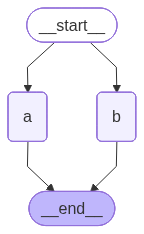

In [11]:
class State(TypedDict):
    pass


builder = StateGraph(State)


def node_a(state: State):
    print("executing a")
    sleep(10)
    print("finishing a")


def node_b(state: State):
    print("executing b")
    sleep(10)
    print("execution b")


builder.add_node("a", node_a)
builder.add_node("b", node_b)

builder.add_edge(START, "a")
builder.add_edge(START, "b")
graph = builder.compile()
graph

The project's invocation is represented in the following cell:

In [12]:
graph.invoke(State())

executing a
executing b
finishing a
execution b


It follows from the result that flows was executed in parallel.

## Tool node

The `langgraph.prebuilt.ToolNode` is a special class automatically invokes a tool if the previous message contains a tool invocation.

---

The following cell creates a graph that uses the `ToolNode` right after the model invocation.

In [10]:
def kobak_transformation(inp: str) -> str:
    '''
    Provides the kobak transformation for `inp`.
    '''
    return inp[::-1]


model = ChatOllama(model="llama3.2:1b", temperature=0)
model_with_tools = model.bind_tools([kobak_transformation])


def tool_calling_llm(state: langgraph.graph.MessagesState):
    return {"messages": [model_with_tools.invoke(state["messages"])]}


graph = (
    langgraph.graph.StateGraph(langgraph.graph.MessagesState)

    .add_node("tool_calling_llm", tool_calling_llm)
    .add_node(
        "tools",
        langgraph.prebuilt.ToolNode([kobak_transformation])
    )

    .add_edge("__start__", "tool_calling_llm")
    .add_edge("tool_calling_llm", "tools")
    .add_edge("tools", "__end__")

    .compile()
)

The following cell triggers the graph to be executed use the tool call. You can then see the result.

In [11]:
ans = graph.invoke(
    {"messages": [
        langchain_core.messages.HumanMessage(
            "Perform kobak transformation for 'hello'"
        )
    ]}
)

for m in ans["messages"]:
    m.pretty_print()

================================ Human Message =================================

Perform kobak transformation for 'hello'
================================== Ai Message ==================================
Tool Calls:
  kobak_transformation (36d1ffe4-6bde-4e14-971d-8eb94e1483c7)
 Call ID: 36d1ffe4-6bde-4e14-971d-8eb94e1483c7
  Args:
    inp: hello
================================= Tool Message =================================
Name: kobak_transformation

olleh


## Subgraph

You can add additional graphs as regular nodes to your main graph.

---

The following cell defines a simple graph that we will use as as included graph. This graph simply prints a message to indicate that it has been invoked.

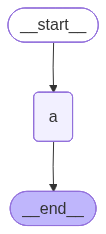

In [13]:
class State(TypedDict):
    pass


def subgraph_node(state: State):
    print("Subgraph invoked")


subgraph = (
    StateGraph(State)
    .add_node("a", subgraph_node)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile()
)
subgraph

The following cell incorporates the `subraph` into the main graph and invokes the final graph.

In [19]:
def outher_node(state: State) -> State:
    print("Outer node invoked")


graph = (
    StateGraph(State)

    .add_node("node", outher_node)
    .add_node("subgraph", subgraph)

    .add_edge(START, "node")
    .add_edge("node", "subgraph")
    .add_edge("subgraph", END)

    .compile()
)
graph.invoke(State())

Outer node invoked
Subgraph invoked


As a result, both the messages specified by the `subgraph` and the outer `graph` are printed.

**Note** For some reason the langgraph fails to create a schema for graphs that include subgraphs.

## Multiple schemas

Although there is one schema for the state, but the nodes can communicate with each other using different shcemas. This does not constitute a state; it is simply information passed from one node to the next.

---

The following cell defines the `OverallState` schema for state and the `InternalSchema` for communication between `node1` and `node2`.

In [2]:
class OverallState(TypedDict):
    foo: str


class InternalSchema(TypedDict):
    bar: str


def node1(state: OverallState) -> InternalSchema:
    return InternalSchema(bar="internal")


def node2(state: InternalSchema) -> OverallState:
    print("Internal step:", dict(state))
    return OverallState(foo="output")


graph = (
    StateGraph(OverallState)
    .add_node("node1", node1)
    .add_node("node2", node2)

    .add_edge(START, "node1")
    .add_edge("node1", "node2")
    .add_edge("node2", END)

    .compile()
)
graph.invoke(OverallState(foo="input"))

Internal step: {'bar': 'internal'}


{'foo': 'output'}

Everything goes fine: `node2` receives the information in the format defined by the `InternalSchema`.